# XCC_ECF_BALANCE re-trained

## **前置作業**

 ### Import

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tqdm import tqdm,trange

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 

### **路徑確認**

In [2]:
filepath= '/kaggle/input/food-dataset/food_dataset/'
os.listdir(filepath)

['train_e', 'test_e']

### image size and batch size

In [3]:
imgSize=(300,300)
imgShape=(300,300,3)
batchSize= 64

### Training Data Import and Augmentation

In [4]:
trainDataGenerator = ImageDataGenerator(rescale = 1/255,
                      # augmentation
                    rotation_range = 0.2,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    zoom_range=0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    validation_split=0.2)
valDataGenerator = ImageDataGenerator(rescale=1/255,validation_split=0.2)

trainBatch = trainDataGenerator.flow_from_directory(
    directory = filepath+'train_e',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='training'
)

valBatch = valDataGenerator.flow_from_directory(
    directory = filepath+'train_e',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='validation'
)
print(trainBatch.class_indices)

Found 22343 images belonging to 50 classes.
Found 5560 images belonging to 50 classes.
{'banana': 0, 'bean sprouts': 1, 'blackpepperporkloin': 2, 'braisedchickenleg': 3, 'braisedegg': 4, 'cabbagebraised': 5, 'carrotscrambledegg': 6, 'cherrytomato': 7, 'cornscrambledegg': 8, 'crispyfishfillet': 9, 'currychicken': 10, 'dalu mei': 11, 'date': 12, 'ebaicai': 13, 'fushan lettuce': 14, 'gailan': 15, 'garlicwhitemeat': 16, 'grape': 17, 'guaizairou': 18, 'hakka stir-fry': 19, 'kale': 20, 'kanto stew': 21, 'kongxincai': 22, 'liuding': 23, 'mapodoufu': 24, 'mazuantsu': 25, 'mcdonaldsnuggets': 26, 'mixedfriednoodles': 27, 'onionscrambledegg': 28, 'orange': 29, 'organicqingsongcai': 30, 'organicxiaomucai': 31, 'papaya': 32, 'pineapple': 33, 'potatostewedmeat': 34, 'qingjiangcai': 35, 'rapeseed': 36, 'rice': 37, 'saltpepperchicken': 38, 'sanbeiji': 39, 'sataymeat': 40, 'sesameoilchicken': 41, 'spaghetti': 42, 'spinach': 43, 'steamedegg': 44, 'sweetandsoursmallsquares': 45, 'tahitianseafood': 46, 't

### **處理資料不平衡問題**

利用class weight調整計算loss時各labels錯誤時增加loss的比例

In [5]:
from sklearn.utils.class_weight import compute_class_weight

# 計算類別權重
print(trainBatch.labels)
# 獲取整個數據集的標籤
all_labels = trainBatch.labels
print(len(all_labels))
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

[ 0  0  0 ... 49 49 49]
22343
{0: 0.8761960784313726, 1: 0.8527862595419847, 2: 1.0202283105022831, 3: 0.8321415270018622, 4: 0.9064097363083164, 5: 1.1728608923884514, 6: 0.9009274193548387, 7: 0.8199266055045872, 8: 1.0179043280182232, 9: 0.8336940298507463, 10: 0.9156967213114754, 11: 0.9735511982570806, 12: 0.8095289855072464, 13: 0.9952338530066815, 14: 5.319761904761905, 15: 1.151701030927835, 16: 1.0767710843373495, 17: 0.9974553571428572, 18: 0.8676893203883496, 19: 0.9138241308793456, 20: 1.6736329588014982, 21: 1.0320092378752888, 22: 0.8544168260038241, 23: 0.9778118161925602, 24: 0.9799561403508772, 25: 1.1255919395465994, 26: 1.063952380952381, 27: 0.888389662027833, 28: 1.1341624365482232, 29: 0.9082520325203252, 30: 1.4141139240506329, 31: 1.0899024390243903, 32: 0.8610019267822736, 33: 0.9651403887688985, 34: 1.0109954751131223, 35: 1.1636979166666668, 36: 0.9527931769722815, 37: 1.108833746898263, 38: 0.929022869022869, 39: 1.0440654205607476, 40: 1.0925672371638142, 4

### **儲存class list**

用以後面資料視覺化方便，以及規定測試及資料引入時的順序

In [6]:
classlist = []
for k, v in trainBatch.class_indices.items():
    classlist.append(k)
    
print(classlist)

['banana', 'bean sprouts', 'blackpepperporkloin', 'braisedchickenleg', 'braisedegg', 'cabbagebraised', 'carrotscrambledegg', 'cherrytomato', 'cornscrambledegg', 'crispyfishfillet', 'currychicken', 'dalu mei', 'date', 'ebaicai', 'fushan lettuce', 'gailan', 'garlicwhitemeat', 'grape', 'guaizairou', 'hakka stir-fry', 'kale', 'kanto stew', 'kongxincai', 'liuding', 'mapodoufu', 'mazuantsu', 'mcdonaldsnuggets', 'mixedfriednoodles', 'onionscrambledegg', 'orange', 'organicqingsongcai', 'organicxiaomucai', 'papaya', 'pineapple', 'potatostewedmeat', 'qingjiangcai', 'rapeseed', 'rice', 'saltpepperchicken', 'sanbeiji', 'sataymeat', 'sesameoilchicken', 'spaghetti', 'spinach', 'steamedegg', 'sweetandsoursmallsquares', 'tahitianseafood', 'tomatoscrambledegg', 'watermelon', 'waxapple']


In [7]:
testDataGenerator = ImageDataGenerator(rescale=1/255)
testBatch = testDataGenerator.flow_from_directory(
    directory='/kaggle/input/food-dataset/food_dataset/test_e',
    class_mode='categorical',  # 使用 'categorical' 模式
    batch_size=batchSize,
    target_size=imgSize,
    shuffle=False,  # 確保不打亂順序
    classes=classlist
     # 包含所有類別名稱
)

Found 7002 images belonging to 50 classes.


## **模型引入及設置**

In [8]:
from tensorflow.keras.applications import InceptionResNetV2, Xception, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, concatenate, Input
from tensorflow.keras.models import Model
import h5py

### Xception + EfficientNetV2L

In [9]:
base_model1 = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=imgShape,
)
base_model2 = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=imgShape,
    include_preprocessing=False
    
)

473176280/473176280 [==============================] - 2s 0us/step


In [10]:
#base_model1.summary()

In [11]:
#base_model2.summary()

In [12]:
input1 = Input(shape=imgShape, name='input_1')
x1 = GlobalAveragePooling2D()(base_model1(input1))
x2 = GlobalAveragePooling2D()(base_model2(input1))
#x3 = GlobalAveragePooling2D()(base_model3(input1))
merged = concatenate([x1, x2])
x = layers.BatchNormalization()(merged)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
output_layer = layers.Dense(units = 50, activation = 'softmax')(x)

重新訓練權重

In [13]:
for layer in base_model1.layers:
    layer.trainable = False
for layer in base_model1.layers[-10:]:
    layer.trainable = True
    
for layer in base_model2.layers:
    layer.trainable = False
for layer in base_model2.layers[-7:]:
    layer.trainable = True

In [14]:
combined_model = Model(inputs= input1, outputs=output_layer)
print(input1.shape)

(None, 300, 300, 3)


In [15]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import math

def lr_decay(epoch):
    initial_lr = 0.01
    decay_factor = 0.1
    decay_epochs = 5
    lrate = initial_lr * math.pow(decay_factor, math.floor((1 + epoch) / decay_epochs))
    return lrate

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 7)
lr_scheduler = LearningRateScheduler(lr_decay)

combined_model.compile(optimizer = Nadam(), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k = 5, name = 'top_5_categorical_accuracy', dtype = None)])

In [16]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="/kaggle/working/model_concat2_balance_test_out.h5", verbose=1, save_best_only=True)

## **模型訓練**

In [17]:
import numpy as np
epoch=20

history = combined_model.fit(
   trainBatch,
    steps_per_epoch = trainBatch.samples // batchSize,
    validation_data = valBatch,
    validation_steps = valBatch.samples // batchSize,
    epochs=epoch,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_scheduler, checkpointer]
)

Epoch 1/20


2023-12-27 13:08:46.858680: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-l/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


349/349 [==============================] - ETA: 0s - loss: 1.4422 - accuracy: 0.5937 - top_5_categorical_accuracy: 0.9011
Epoch 1: val_loss improved from inf to 0.88107, saving model to /kaggle/working/model_concat2_balance_test_out.h5
349/349 [==============================] - 768s 2s/step - loss: 1.4422 - accuracy: 0.5937 - top_5_categorical_accuracy: 0.9011 - val_loss: 0.8811 - val_accuracy: 0.7293 - val_top_5_categorical_accuracy: 0.9664 - lr: 0.0100
Epoch 2/20
349/349 [==============================] - ETA: 0s - loss: 0.9228 - accuracy: 0.7174 - top_5_categorical_accuracy: 0.9596
Epoch 2: val_loss improved from 0.88107 to 0.68718, saving model to /kaggle/working/model_concat2_balance_test_out.h5
349/349 [==============================] - 670s 2s/step - loss: 0.9228 - accuracy: 0.7174 - top_5_categorical_accuracy: 0.9596 - val_loss: 0.6872 - val_accuracy: 0.7778 - val_top_5_categorical_accuracy: 0.9789 - lr: 0.0100
Epoch 3/20
349/349 [==============================] - ETA: 0s - los

## **訓練結果**

### loss and accuracy curves

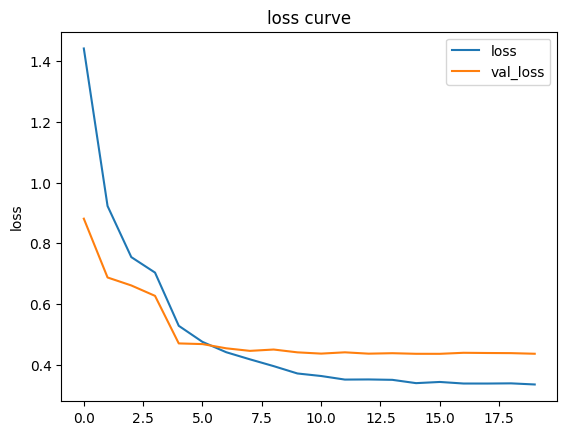

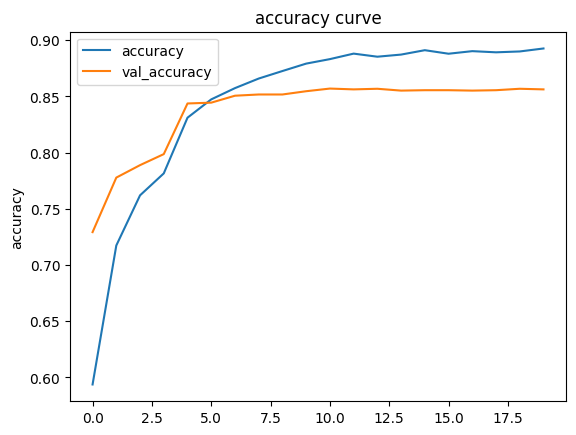

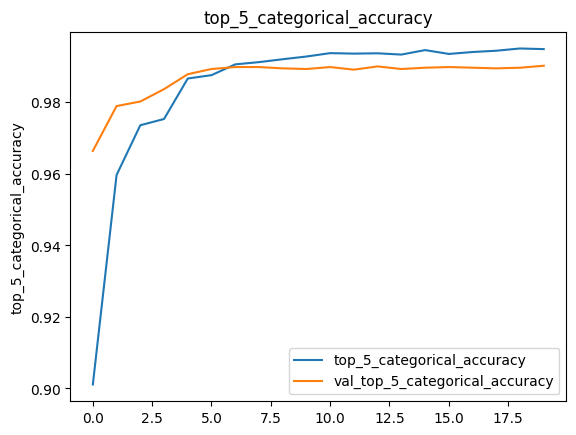

In [18]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.plot(history.history['top_5_categorical_accuracy'],label='top_5_categorical_accuracy')
plt.plot(history.history['val_top_5_categorical_accuracy'],label='val_top_5_categorical_accuracy')
plt.title('top_5_categorical_accuracy')
plt.ylabel('top_5_categorical_accuracy')
plt.legend()
plt.show()

### Confusion_Matrix (Test)

In [19]:
import time

start_time = time.time()
predictions = combined_model.predict_generator(testBatch)
end_time = time.time()

predicted_classes = np.argmax(predictions, axis=1)
true_classes = testBatch.classes

In [20]:
prediction_time = end_time - start_time
print(f"預測時間：{prediction_time/7002} 秒")

預測時間：0.01579163905996079 秒


In [21]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

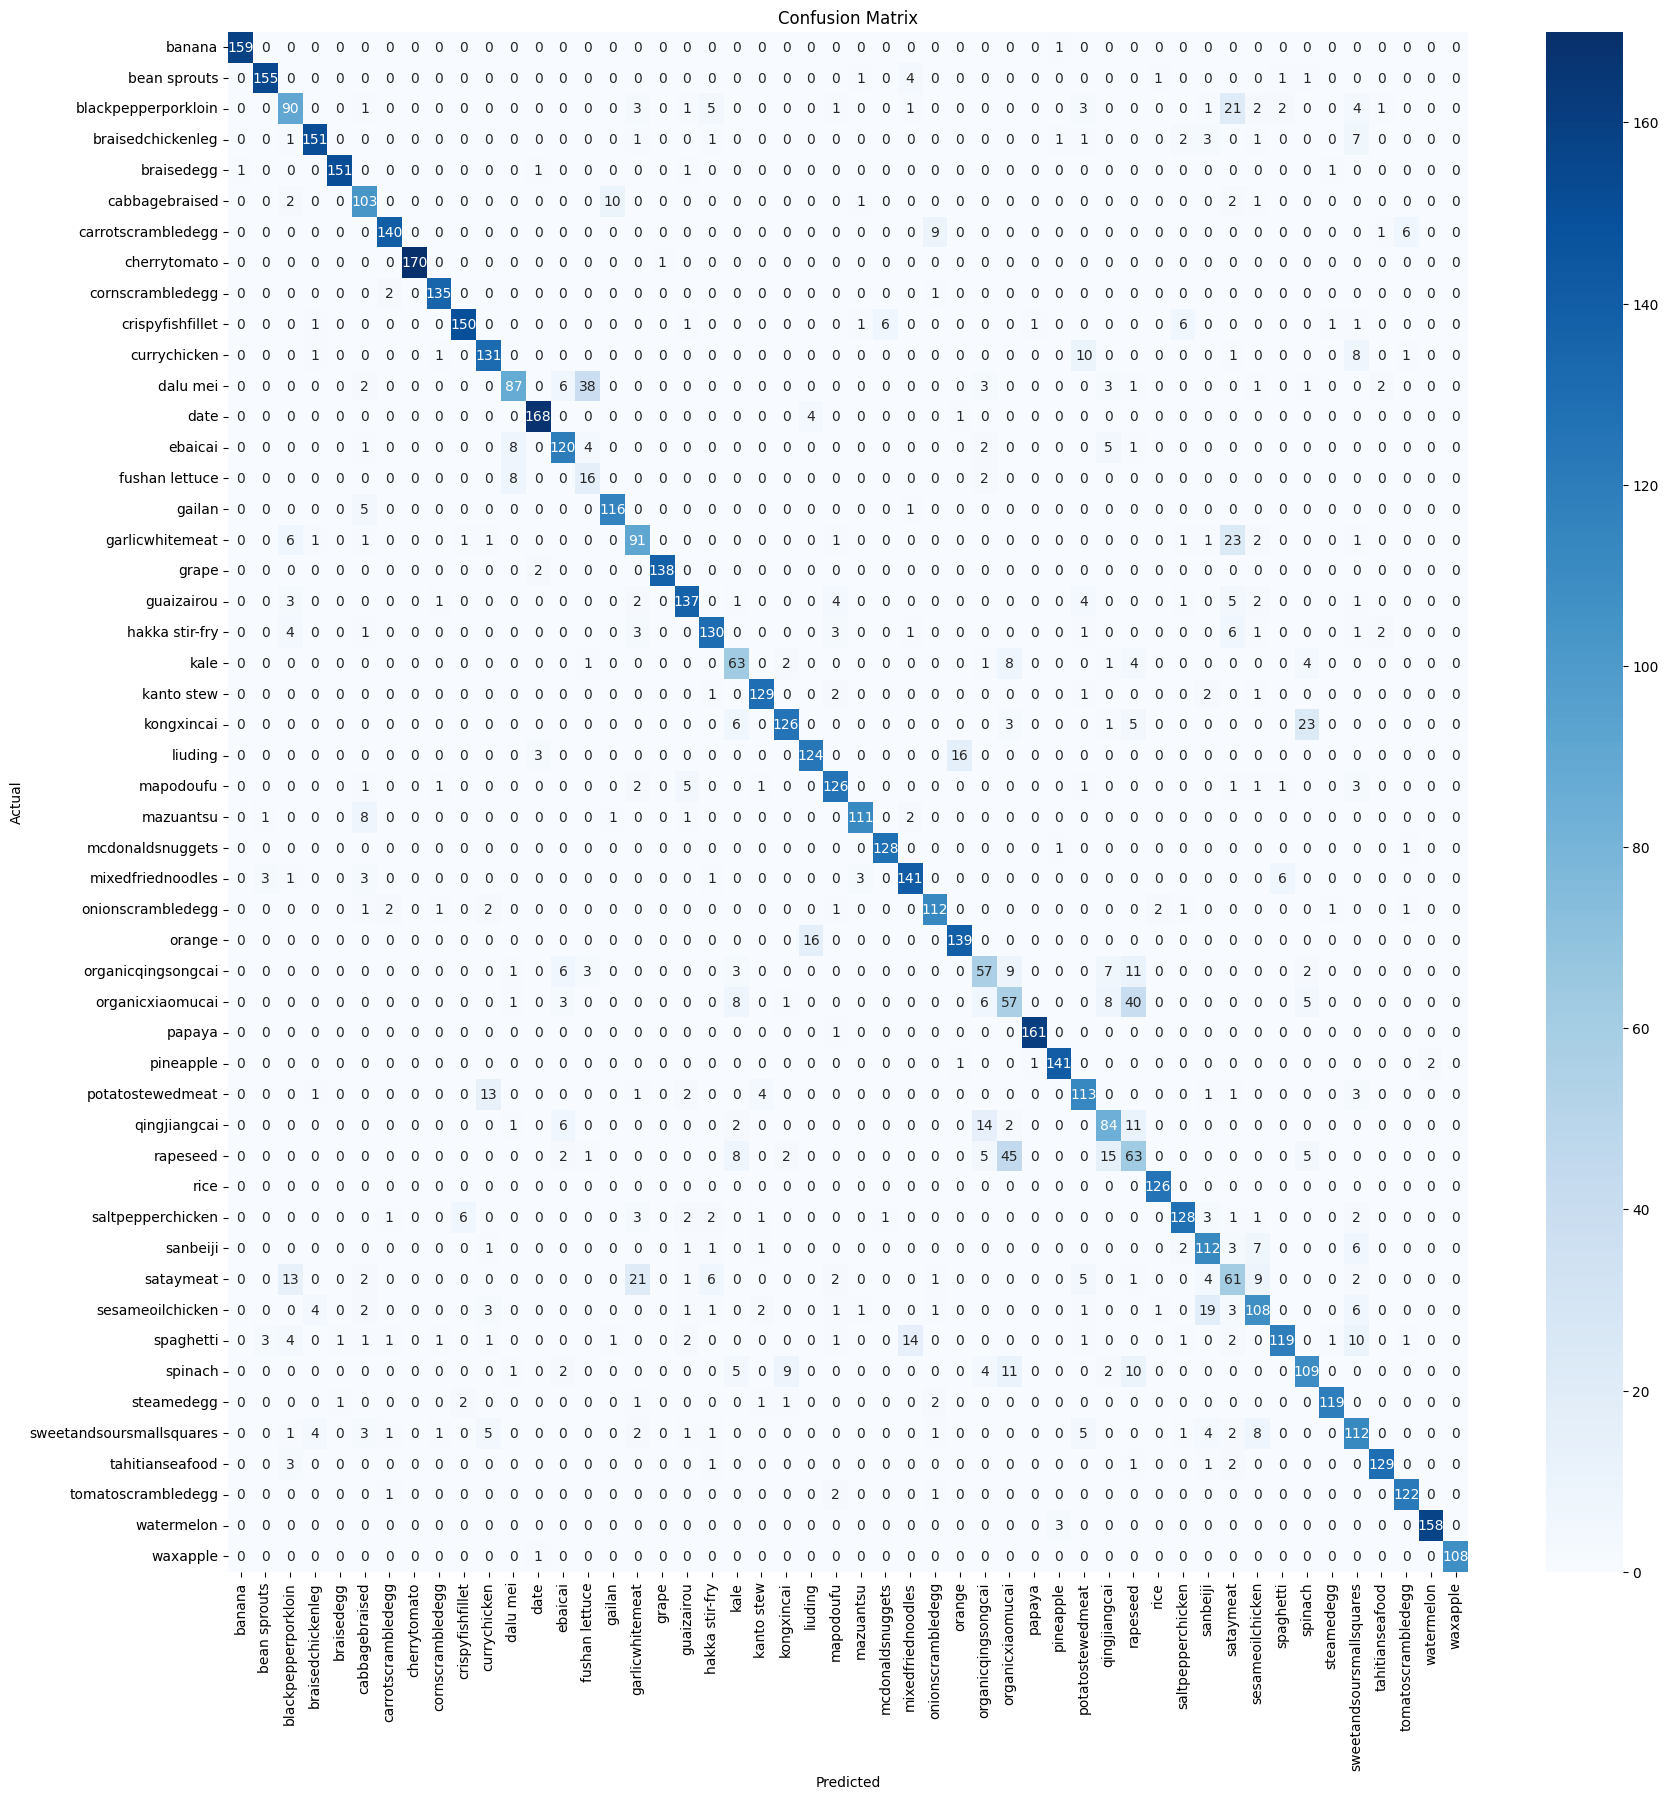

In [22]:
import seaborn as sns
plt.figure(figsize=(20,20))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels = classlist, yticklabels = classlist)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Accuracy

In [23]:
accuracy = np.trace(confusion_mtx) / np.sum(confusion_mtx)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8460439874321622


### Classification Report

In [24]:
from sklearn.metrics import classification_report

# 生成分類報告
report = classification_report(true_classes, predicted_classes, target_names=classlist)

# 打印分類報告
print(report)

                          precision    recall  f1-score   support

                  banana       0.99      0.99      0.99       160
            bean sprouts       0.96      0.95      0.95       163
     blackpepperporkloin       0.70      0.66      0.68       136
       braisedchickenleg       0.93      0.89      0.91       169
              braisedegg       0.99      0.97      0.98       155
          cabbagebraised       0.76      0.87      0.81       119
      carrotscrambledegg       0.95      0.90      0.92       156
            cherrytomato       1.00      0.99      1.00       171
        cornscrambledegg       0.96      0.98      0.97       138
        crispyfishfillet       0.94      0.89      0.92       168
            currychicken       0.83      0.86      0.85       153
                dalu mei       0.81      0.60      0.69       144
                    date       0.96      0.97      0.97       173
                 ebaicai       0.83      0.85      0.84       141
         

### **觀察 Train data**

In [25]:
trainDataGenerator2 = ImageDataGenerator(rescale = 1/255,)
trainBatch2 = trainDataGenerator2.flow_from_directory(
    directory = filepath+'train_e',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = False,
    batch_size = batchSize,
    subset='training',
    classes=classlist
)


print(trainBatch2.class_indices)

Found 27903 images belonging to 50 classes.
{'banana': 0, 'bean sprouts': 1, 'blackpepperporkloin': 2, 'braisedchickenleg': 3, 'braisedegg': 4, 'cabbagebraised': 5, 'carrotscrambledegg': 6, 'cherrytomato': 7, 'cornscrambledegg': 8, 'crispyfishfillet': 9, 'currychicken': 10, 'dalu mei': 11, 'date': 12, 'ebaicai': 13, 'fushan lettuce': 14, 'gailan': 15, 'garlicwhitemeat': 16, 'grape': 17, 'guaizairou': 18, 'hakka stir-fry': 19, 'kale': 20, 'kanto stew': 21, 'kongxincai': 22, 'liuding': 23, 'mapodoufu': 24, 'mazuantsu': 25, 'mcdonaldsnuggets': 26, 'mixedfriednoodles': 27, 'onionscrambledegg': 28, 'orange': 29, 'organicqingsongcai': 30, 'organicxiaomucai': 31, 'papaya': 32, 'pineapple': 33, 'potatostewedmeat': 34, 'qingjiangcai': 35, 'rapeseed': 36, 'rice': 37, 'saltpepperchicken': 38, 'sanbeiji': 39, 'sataymeat': 40, 'sesameoilchicken': 41, 'spaghetti': 42, 'spinach': 43, 'steamedegg': 44, 'sweetandsoursmallsquares': 45, 'tahitianseafood': 46, 'tomatoscrambledegg': 47, 'watermelon': 48, '

In [26]:
import time

start_time2 = time.time()
predictions2 = combined_model.predict_generator(trainBatch2)
end_time2 = time.time()
predicted_classes2 = np.argmax(predictions2, axis=1)
prediction_time2 = end_time2 - start_time2
print(f"預測時間：{prediction_time2/27903} 秒")

預測時間：0.014413363855893273 秒


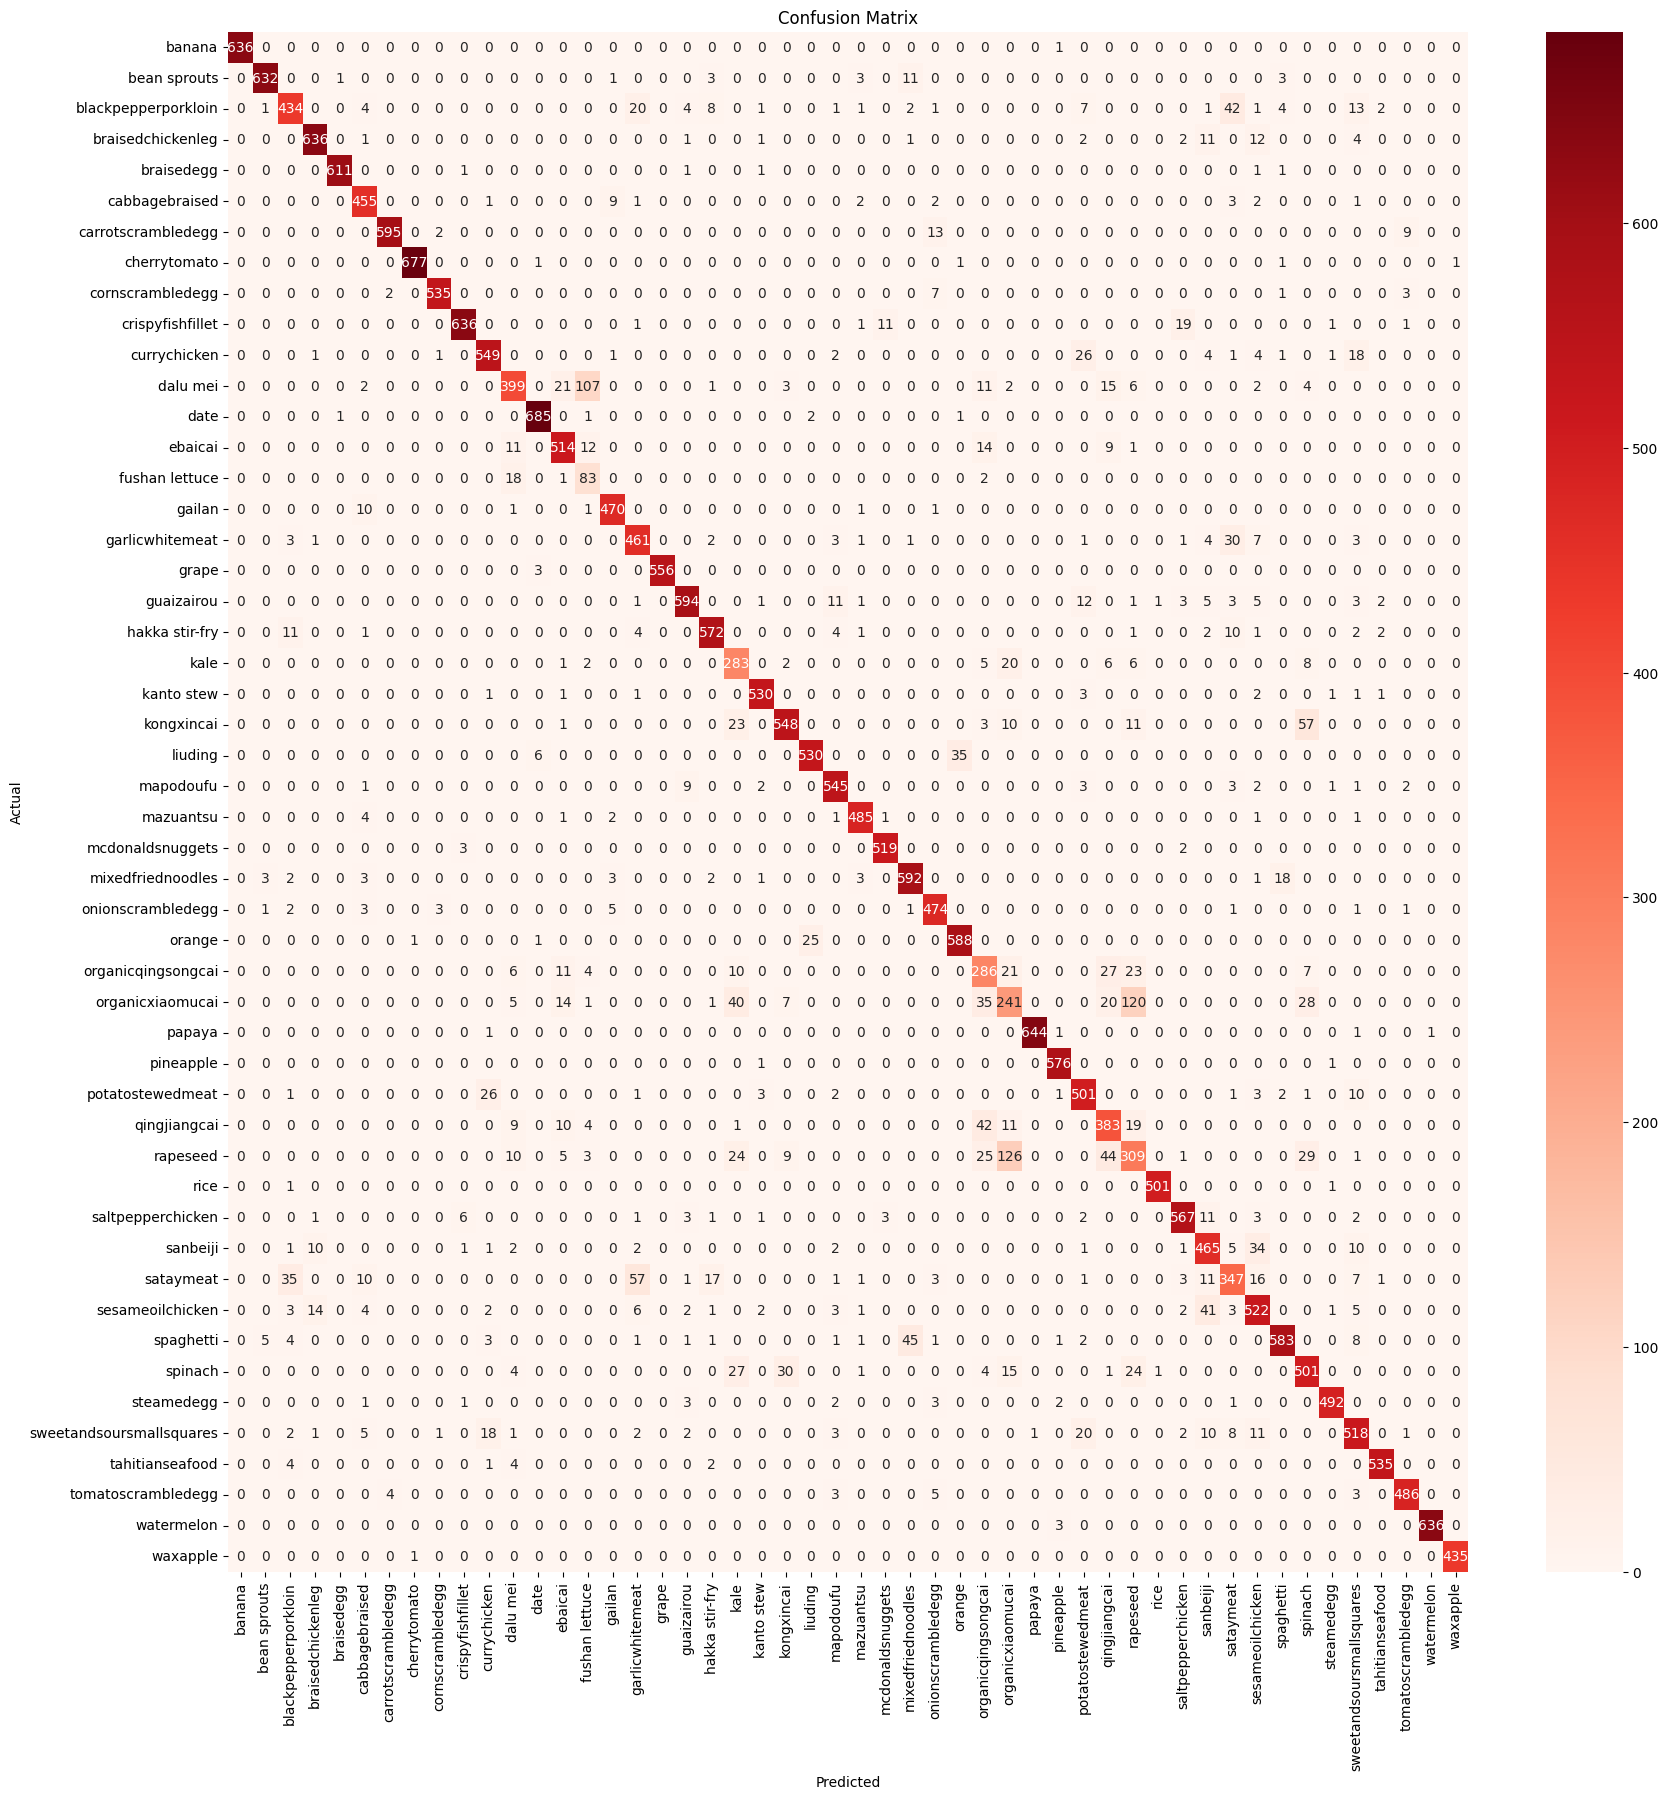

In [27]:
true_classes = trainBatch2.classes
confusion_mtx2 = confusion_matrix(true_classes, predicted_classes2)
plt.figure(figsize=(20,20))
sns.heatmap(confusion_mtx2, annot=True, fmt="d", cmap="Reds", xticklabels = classlist, yticklabels = classlist)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
accuracy2 = np.trace(confusion_mtx2) / np.sum(confusion_mtx2)
print(f'Accuracy: {accuracy2}')

Accuracy: 0.9085761387664408


In [29]:
report2 = classification_report(true_classes, predicted_classes2, target_names=classlist)
print(report2)

                          precision    recall  f1-score   support

                  banana       1.00      1.00      1.00       637
            bean sprouts       0.98      0.97      0.98       654
     blackpepperporkloin       0.86      0.79      0.83       547
       braisedchickenleg       0.96      0.95      0.95       671
              braisedegg       1.00      0.99      0.99       616
          cabbagebraised       0.90      0.96      0.93       476
      carrotscrambledegg       0.99      0.96      0.98       619
            cherrytomato       1.00      0.99      1.00       681
        cornscrambledegg       0.99      0.98      0.98       548
        crispyfishfillet       0.98      0.95      0.97       670
            currychicken       0.91      0.90      0.91       609
                dalu mei       0.85      0.70      0.77       573
                    date       0.98      0.99      0.99       690
                 ebaicai       0.89      0.92      0.90       561
         